In [ ]:
!pip uninstall -y qiskit qiskit-aer qiskit-aqua qiskit-ignis qiskit-terra qiskit-ibmq-provider qiskit-ibm-provider qiskit-ibm-runtime
!pip cache purge
!pip install --no-cache-dir qiskit
!pip install --no-cache-dir qiskit-aer
!pip install --no-cache-dir qiskit-ibm-runtime
!pip install pylatexenc


Files removed: 2946
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 178.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 178.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 285.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 172.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 263.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata

In [ ]:
# Import necessary libraries
import time
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit.transpiler import CouplingMap, Layout, PassManager
from qiskit.transpiler.passes import Layout2qDistance
from networkx.algorithms import community

# Set up IBM Quantum account and backend
IBM_QUANTUM_API_TOKEN = '-'
QiskitRuntimeService.save_account(channel='ibm_quantum', token=IBM_QUANTUM_API_TOKEN, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')


# Choose to use the simulator or real backend
use_simulator = False


In [ ]:
# Get the IBM Sherbrooke backend or simulator
if use_simulator:
    backend = AerSimulator()  # Use AerSimulator for local testing
else:
    # Use IBM Sherbrooke backend
    backends = service.backends(simulator=False, operational=True)
    backend = next(backend for backend in backends if backend.name == 'ibm_sherbrooke')
    print(f"Selected backend: {backend.name}")


Selected backend: ibm_sherbrooke


In [ ]:
# Define your quantum circuit
def create_sample_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.barrier()
    qc.measure_all()
    return qc

# Set up circuit parameters
num_qubits_circuit = 4  # Circuit uses 4 qubits
num_copies = 9  # Number of copies to pack on the QPU
user_circuit = create_sample_circuit(num_qubits_circuit)

# Build the coupling graph from the backend configuration
coupling_map = backend.configuration().coupling_map
G = nx.Graph()
G.add_edges_from(coupling_map)

# Partition the qubits into zones using community detection
zones = list(community.greedy_modularity_communities(G))

# Adjust the number of copies based on available zones
if len(zones) < num_copies:
    print(f"Only {len(zones)} zones are available, adjusting the number of copies to {len(zones)}.")
    num_copies = len(zones)


In [ ]:
# Use Layout2qDistance to optimize qubit placement
pass_manager = PassManager()
pass_manager.append(Layout2qDistance(CouplingMap(coupling_map)))

# Transpile each copy of the circuit into different zones
transpiled_circuits = []
for i in range(num_copies):
    qc = user_circuit.copy()
    zone_qubits = list(zones[i])[:num_qubits_circuit]

    # Define the initial layout (map logical qubits to physical qubits)
    initial_layout = {qc.qubits[j]: zone_qubits[j] for j in range(num_qubits_circuit)}

    # Transpile the circuit with optimized layout and crosstalk mitigation
    transpiled_qc = transpile(qc, backend=backend, coupling_map=CouplingMap(coupling_map),
                              initial_layout=initial_layout, optimization_level=3)

    # Run the pass manager for Layout2qDistance
    transpiled_qc = pass_manager.run(transpiled_qc)

    # Append the transpiled circuit
    transpiled_circuits.append(transpiled_qc)


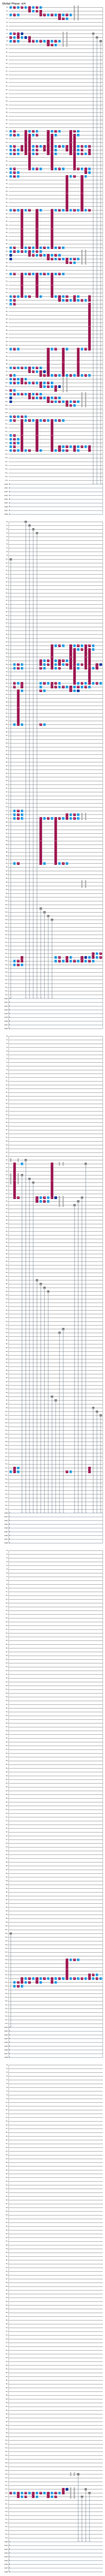

In [ ]:
# Create a combined circuit with all the transpiled circuits
combined_circuit = QuantumCircuit(backend.configuration().n_qubits)

for i, qc in enumerate(transpiled_circuits):
    classical_register = ClassicalRegister(num_qubits_circuit, f'creg{i}')
    combined_circuit.add_register(classical_register)
    combined_circuit.compose(qc, inplace=True)

combined_circuit.draw('mpl', scale = 0.3)


In [ ]:
# Transpile the combined circuit for the backend
transpiled_combined_circuit = transpile(combined_circuit, backend=backend)

# Execute the transpiled circuit on the backend (simulator or real hardware)
total_shots = 1024
if use_simulator:
    job = backend.run(transpiled_combined_circuit, shots=total_shots)
else:
    job = backend.run(transpiled_combined_circuit, shots=total_shots)
    print(f"Job ID: {job.job_id()}")


<ipython-input-8-25d4752a7bcc>:9: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_combined_circuit, shots=total_shots)


Job ID: cvw0dhehsshg008zxgq0


In [ ]:
# Retrieve the results once the job is complete
result = job.result()

# Step 9: Extract and process the result counts
counts = result.get_counts()
separated_counts = []

for i in range(num_copies):
    start_clbit = i * num_qubits_circuit
    counts_i = {}

    for outcome, count in counts.items():
        # Split the outcome into separate registers
        bits = outcome.zfill(backend.configuration().n_qubits)
        # Extract bits corresponding to this circuit copy
        outcome_i = bits[start_clbit:start_clbit + num_qubits_circuit]
        counts_i[outcome_i] = counts_i.get(outcome_i, 0) + count

    separated_counts.append(counts_i)

# Step 10: Print the separated counts for each circuit copy
for i, counts in enumerate(separated_counts):
    print(f"Counts for circuit copy {i+1}: {counts}")


Counts for circuit copy 1: {'0000': 1024}
Counts for circuit copy 2: {'0000': 1024}
Counts for circuit copy 3: {'0000': 1024}
Counts for circuit copy 4: {'0000': 1024}
Counts for circuit copy 5: {'0000': 1024}
Counts for circuit copy 6: {'0000': 1024}
Counts for circuit copy 7: {'0000': 1024}
Counts for circuit copy 8: {'0000': 1024}
Counts for circuit copy 9: {'0000': 1024}
